In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#   device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cpu


# Prepare the data

In [6]:
# Load the data

X_train_valid = np.load("X_train_valid.npy")
X_test = np.load("X_test.npy")
y_train_valid = np.load("y_train_valid.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
person_test = np.load("person_test.npy")

print(f'Training/Validation Features: {X_train_valid.shape}')
print(f'Test Features: {X_test.shape}')
print()

print(f'Training/Validation Labels: {y_train_valid.shape}')
print(f'Test Labels: {y_test.shape}')
print()

print(f'Person Training/Validation Data: {person_train_valid.shape}')
print(f'Person Test Data: {person_test.shape}')
print()

Training/Validation Features: (2115, 22, 1000)
Test Features: (443, 22, 1000)

Training/Validation Labels: (2115,)
Test Labels: (443,)

Person Training/Validation Data: (2115, 1)
Person Test Data: (443, 1)



Our training data consists of **2115 trials**, each of which has data collected from **22 electrodes** across **1000 time steps**.

The "person" data tells us which participant (out of 9) was the one the trial was conducted on, i.e. `person_train_valid[0]` gives the "id" for the participant of the first trial in our training data, resulting in the data in `X_train_valid[0]`.

In [7]:
# Process the data

## Adjust the labels s.t.
##   Cue onset left - 0
##   Cue onset right - 1
##   Cue onset foot - 2
##   Cue onset tongue - 3
y_train_valid -= 769
y_test -= 769

## Split the training and validation data
idx_valid = np.random.choice(2115, 500, replace=False)
idx_train = np.array(list(set(range(2115)).difference(set(idx_valid))))

(X_train, X_valid) = X_train_valid[idx_train], X_train_valid[idx_valid] 
(y_train, y_valid) = y_train_valid[idx_train], y_train_valid[idx_valid]

print('Shape of training set:',X_train.shape)
print('Shape of validation set:',X_valid.shape)
print('Shape of validation set:',X_test.shape)
print()
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of validation labels:',y_test.shape)
print()

# Add explicit width to be compatible with torch's Conv2D implementation expecting an input of (N, C, H, W)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print('Shape of training set after adding explicit width:',X_train.shape)
print('Shape of validation set after adding explicit width:',X_valid.shape)
print('Shape of test set after adding explicit width:',X_test.shape)

Shape of training set: (1615, 22, 1000)
Shape of validation set: (500, 22, 1000)
Shape of validation set: (443, 22, 1000)

Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of validation labels: (443,)

Shape of training set after adding explicit width: (1615, 22, 1000, 1)
Shape of validation set after adding explicit width: (500, 22, 1000, 1)
Shape of test set after adding explicit width: (443, 22, 1000, 1)


In [8]:
# Wrap the data into a pytorch `Dataset`

class EEGDataset(Dataset):
  def __init__(self, type="train", transform_data=None, transform_labels=None):
    if type == "val":
      self.data = X_valid
      self.labels = y_valid
    elif type == "test":
      self.data = X_test
      self.labels = y_test
    else:
      self.data = X_train
      self.labels = y_train

    self.data = torch.from_numpy(self.data)
    self.labels = torch.from_numpy(self.labels).long() # cel expects long instead of int

    if transform_data:
        self.data = transform_data(self.data)
    if transform_labels:
        self.labels = transform_labels(self.labels)

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    data = self.data[idx]
    label = self.labels[idx]
    return data, label

In [9]:
print(X_train.dtype)
print(y_train.dtype)

float64
int32


In [10]:
torch.set_default_dtype(torch.float64) # set default dtype so that models have params with dtypes that matches the data's

# Model (TonmoyCnn)

## Create model

In [11]:
class TonmoyCnn(nn.Module):
    """ A pytorch port of Tonmoy's discussion 6 model 

    Dimension of FC layer is hardcoded s.t. it works when the NN is fed in data with 500 time steps
    """
    def __init__(self):
        super(TonmoyCnn, self).__init__()

        # Declare some fixed parameters
        num_in_channels = 22
        num_output_classes = 4
        num_filters_c1 = 25
        num_filters_c2 = 50
        num_filters_c3 = 100
        num_filters_c4 = 200

        # Declare layers
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(in_channels=num_in_channels, out_channels=num_filters_c1, kernel_size=(10,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c1),
            nn.Dropout(p=0.5)
        )
        
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c1, out_channels=num_filters_c2, kernel_size=(10,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c2),
            nn.Dropout(p=0.5)
        )
        
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c2, out_channels=num_filters_c3, kernel_size=(10,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c3),
            nn.Dropout(p=0.5)
        )
        
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c3, out_channels=num_filters_c4, kernel_size=(10,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c4),
            nn.Dropout(p=0.5)
        )

        self.FCLayer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1400, num_output_classes)
        )

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = self.FCLayer(x)
        return x

In [35]:
# Create and verify model

## Instantiate model
model = TonmoyCnn().to(device)
print("###########################")
print("#    Layer Parameters     #")
print("###########################")
print()
print(model)
print()

## Test model on dummy data
batch_size = 10
num_chans, height, width = 22, 500, 1  # input dimensions
test_input = torch.randn(batch_size, num_chans, height, width).to(device)
print("###########################")
print("#         Logits          #")
print("###########################")
print()
print(model(test_input).shape)  # should be (batch_size, num_classes) - contains the raw logits(scores) per class for each batch
print()

# Print summary of model 
print("###########################")
print("#      Model Summary      #")
print("###########################")
print()
summary(TonmoyCnn().float(), input_size=(22,500,1)) # note: torchsummary uses float32 as the input dtype

###########################
#    Layer Parameters     #
###########################

TonmoyCnn(
  (ConvLayer1): Sequential(
    (0): Conv2d(22, 25, kernel_size=(10, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(10, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(

In [13]:
loss_fn = nn.CrossEntropyLoss() # declare loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # declare optimization method

## Train model

In [14]:
# Create datasets with any desired augmentations

class TrimTimeSteps(object):
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, X):
        return X[:,:,0:self.output_size,:]

transform_data = TrimTimeSteps(500)

## Create pytorch datasets
training_dataset = EEGDataset(type="train", transform_data=transform_data)
validation_dataset = EEGDataset(type="val", transform_data=transform_data)
test_dataset = EEGDataset(type="test", transform_data=transform_data)

print(f"Length of new training data: {len(training_dataset)}")
print(f"Length of new validation data: {len(validation_dataset)}")
print(f"Length of new test data: {len(test_dataset)}")
print()
print(f"Shape of new training data: {training_dataset[0][0].shape}")
print(f"Shape of new validation data: {validation_dataset[0][0].shape}")
print(f"Shape of new test data: {test_dataset[0][0].shape}")

## Create pytorch dataloaders
bsz = 64
training_dataloader = DataLoader(dataset=training_dataset, batch_size=bsz, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=bsz, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=bsz, shuffle=False)

Length of new training data: 1615
Length of new validation data: 500
Length of new test data: 443

Shape of new training data: torch.Size([22, 500, 1])
Shape of new validation data: torch.Size([22, 500, 1])
Shape of new test data: torch.Size([22, 500, 1])


In [15]:
# Create training loop
def train(loss_vector, accuracy_vector):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    train_loss, train_correct_count = 0, 0
    for batch_idx, (X_batch, y_batch) in enumerate(training_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad() # zero out the gradient buffers
        logits = model(X_batch) # pass data through the network and acquire output
        loss = loss_fn(logits, y_batch) # calculate loss
        loss.backward() # backpropogate
        optimizer.step() # update weights

        # Calculate accuracy
        with torch.no_grad():
            train_loss += loss.data.item()
            y_hat_batch = torch.argmax(logits, dim=-1) # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            train_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    # Store loss and accuracy
    loss_vector.append(train_loss/len(training_dataloader))
    accuracy_vector.append(train_correct_count/len(training_dataloader.dataset))

# Create validation loop
def validate(loss_vector, accuracy_vector):
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the validation set
    val_loss, val_correct_count = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in validation_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            val_loss += loss_fn(logits, y_batch).data.item() # calculate loss
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            val_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    # Store loss and accuracy
    loss_vector.append(val_loss/len(validation_dataloader))
    accuracy_vector.append(val_correct_count/len(validation_dataloader.dataset))

In [16]:
%%time
from time import time

epochs = 50

train_lossv, train_accv = [], []
val_lossv, val_accv = [], []
for epoch in range(1, epochs + 1):
    epoch_start = time()
    train(train_lossv, train_accv)
    validate(val_lossv, val_accv)
    print(f"Epoch {epoch}/{epochs} ({(time() - epoch_start):.2f}s) - train loss: {train_lossv[-1]} - train acc: {train_accv[-1]} - val loss: {val_lossv[-1]} - val acc: {val_accv[-1]}")
    print()

Epoch 1/50 (3.86s) - train loss: 1.538222020635754 - train acc: 0.3219814241486068 - val loss: 1.3452282978077692 - val acc: 0.38

Epoch 2/50 (3.53s) - train loss: 1.42952432759971 - train acc: 0.3702786377708978 - val loss: 1.3810081680813577 - val acc: 0.34

Epoch 3/50 (3.62s) - train loss: 1.365986815917723 - train acc: 0.4055727554179567 - val loss: 1.2950433033339173 - val acc: 0.39

Epoch 4/50 (3.35s) - train loss: 1.3111580033663945 - train acc: 0.40495356037151703 - val loss: 1.4162581418159796 - val acc: 0.374

Epoch 5/50 (3.42s) - train loss: 1.2505271456612432 - train acc: 0.46377708978328175 - val loss: 1.3177131297256806 - val acc: 0.43

Epoch 6/50 (3.35s) - train loss: 1.234409532614262 - train acc: 0.47678018575851394 - val loss: 1.1751706447169024 - val acc: 0.484

Epoch 7/50 (3.65s) - train loss: 1.1382246476957774 - train acc: 0.508359133126935 - val loss: 1.2675902764300604 - val acc: 0.47

Epoch 8/50 (3.67s) - train loss: 1.1436140122047538 - train acc: 0.5201238390

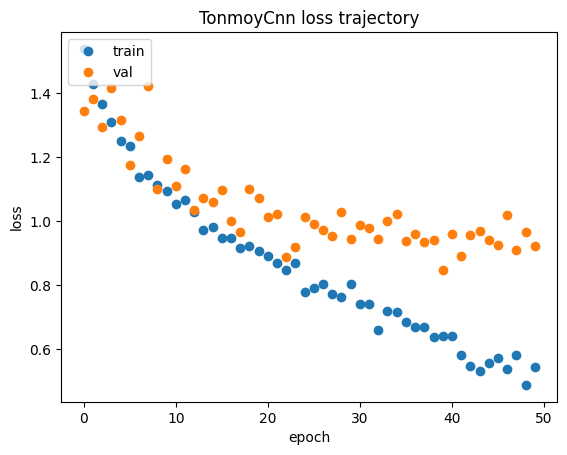

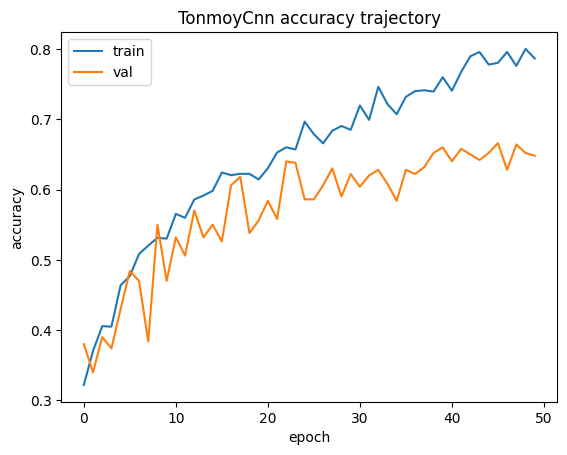

In [17]:
# Plot loss
plt.plot(train_lossv,'o')
plt.plot(val_lossv,'o')
plt.title('TonmoyCnn loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot accuracy
plt.plot(train_accv)
plt.plot(val_accv)
plt.title('TonmoyCnn accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test model

In [22]:
num_classes = 4

def test():
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the test set
    test_correct_count_per_class = np.zeros(4) # no. of correctly classified examples for each class (idx is class_id)
    test_count_per_class = np.zeros(4) # no. of examples for each class (idx is class_id)
    test_correct_count = 0
    with torch.no_grad(): # speed things up because we kn
        for X_batch, y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            test_correct_count += torch.sum(y_hat_batch == y_batch, dim=-1) # accumulate no. of correctly classified examples

            correct_idxs = (y_hat_batch == y_batch)
            for cls in range(num_classes):
                test_count_per_class[cls] += torch.sum(y_batch == cls) # accumulate no. of examples per class
                test_correct_count_per_class[cls] += torch.sum(y_batch[correct_idxs] == cls) # accumulate no. of correctly classified examples per class
                

    accuracy = test_correct_count / len(test_dataloader.dataset)
    # accuracies_per_class = {class_id: acc for class_id, acc in zip(range(num_classes), test_correct_count_per_class/test_count_per_class)}
    accuracies_per_class = test_correct_count_per_class/test_count_per_class

    return accuracy, accuracies_per_class

accuracy, accuracies_per_class = test()
print(f"Total Accuracy: {accuracy}")
for c, acc in enumerate(accuracies_per_class):
    print(f"    - Accuracy for class {c}: {acc}")

Total Accuracy: 0.6659142212189616
    - Accuracy for class 0: 0.5855855855855856
    - Accuracy for class 1: 0.8267716535433071
    - Accuracy for class 2: 0.5625
    - Accuracy for class 3: 0.6513761467889908


# Model (TonmoyCnnLstm)

## Create model

In [107]:
class TonmoyCnnLstm(nn.Module):
    """ A pytorch port of Tonmoy's discussion 7 model 

    Dimension of FC layer is hardcoded s.t. it works when the NN is fed in data with 400 time steps
    """
    def __init__(self):
        super(TonmoyCnnLstm, self).__init__()

        # Declare some fixed parameters
        num_in_channels = 22
        num_output_classes = 4
        num_filters_c1 = 25
        num_filters_c2 = 50
        num_filters_c3 = 100
        num_filters_c4 = 200

        # Declare layers
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(in_channels=num_in_channels, out_channels=num_filters_c1, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c1),
            nn.Dropout(p=0.6)
        )
        
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c1, out_channels=num_filters_c2, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c2),
            nn.Dropout(p=0.6)
        )
        
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c2, out_channels=num_filters_c3, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c3),
            nn.Dropout(p=0.6)
        )
        
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c3, out_channels=num_filters_c4, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c4),
            nn.Dropout(p=0.6)
        )

        self.FcLayer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000, 40)
        )
        
        self.LstmLayer = nn.Sequential(
            # 40 time steps, input (x) of size 1, output (h) of size 10
            nn.LSTM(input_size=1, hidden_size=10, dropout=0.4, batch_first=True)
        )

        self.FcLayer2 = nn.Sequential(
            nn.Linear(10, num_output_classes)
        )

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = self.FcLayer1(x)
        x = x.view(-1, 40, 1) # reshape to (batch_size, time_steps, input_size) that the lstm expects
        x = self.LstmLayer(x)[1][0] # hidden state at the output of the *last* time step
        x = x.view(-1, 10) # (1, N, 10) -> (N, 10)
        x = self.FcLayer2(x)
        return x

In [108]:
# Create and verify model

## Instantiate model
model = TonmoyCnnLstm().to(device)
print("###########################")
print("#    Layer Parameters     #")
print("###########################")
print()
print(model)
print()

## Test model on dummy data
batch_size = 12
num_chans, height, width = 22, 400, 1  # input dimensions
test_input = torch.randn(batch_size, num_chans, height, width).to(device)
print("###########################")
print("#         Logits          #")
print("###########################")
print()
print(model(test_input).shape)  # should be (batch_size, num_classes) - contains the raw logits(scores) per class for each batch
print()

# BUG: https://github.com/sksq96/pytorch-summary/issues/143
# Print summary of model
# print("###########################")
# print("#      Model Summary      #")
# print("###########################")
# print()
# summary(TonmoyCnnLstm().float(), input_size=(22,500,1)) # note: torchsummary uses float32 as the input dtype

###########################
#    Layer Parameters     #
###########################

TonmoyCnnLstm(
  (ConvLayer1): Sequential(
    (0): Conv2d(22, 25, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.6, inplace=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.6, inplace=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=

In [109]:
loss_fn = nn.CrossEntropyLoss() # declare loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # declare optimization method

## Train model

In [110]:
# Create datasets with any desired augmentations

## Define augmentations

class TrimTimeSteps(object):
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, X):
        return X[:,:,0:self.output_size,:]
        

class MaxPool(object):
    def __init__(self, pool_height):
        self.height = pool_height

    def __call__(self, X):
        return torch.max(X.reshape(X.shape[0], X.shape[1], -1, self.height, X.shape[3]), dim=3).values

class AvgPlusNoise(object):
    def __init__(self, pool_height):
        self.height = pool_height

    def __call__(self, X):
        X_avg = torch.mean(X.reshape(X.shape[0], X.shape[1], -1, self.height, X.shape[3]), dim=3)
        return X_avg + torch.normal(0.0, 0.5, X_avg.shape)

class Subsample(object):
    def __init__(self, step, with_noise):
        self.step = step
        self.with_noise = with_noise

    def __call__(self, X):
        X_sub_total = None
        for i in range(self.step):
            X_sub = X[:, :, i::self.step, :] # subsample every self.step time step of X starting with index i
            if self.with_noise:
                X_sub += torch.normal(0.0, 0.5, X_sub.shape) # optionally add noise
                
            # add to list of subsampled data
            if X_sub_total == None:
                X_sub_total = X_sub
            else:
                X_sub_total = torch.vstack((X_sub_total, X_sub))
            
        return X_sub_total

class HDup(object):
    def __init__(self, n):
        self.n = n  # number of samples that will be stacked

    def __call__(self, sample):
        return torch.hstack(tuple(sample for _ in range(self.n)))

## Create training and validation datasets

### Max
tsfrm_max = transforms.Compose([
        TrimTimeSteps(800),
        MaxPool(2)
    ])

train_ds_max = EEGDataset(type="train", transform_data=tsfrm_max)
val_ds_max = EEGDataset(type="val", transform_data=tsfrm_max)

### Average + noise
tsfrm_avg = transforms.Compose([
        TrimTimeSteps(800),
        AvgPlusNoise(2)
    ])

train_ds_avg = EEGDataset(type="train", transform_data=tsfrm_avg)
val_ds_avg = EEGDataset(type="val", transform_data=tsfrm_avg)

### Subsample
tsfrm_subsample = transforms.Compose([
        TrimTimeSteps(800),
        Subsample(2, with_noise=True)
    ])

tsfrm_dup = HDup(2)

train_ds_subsample = EEGDataset(type="train", transform_data=tsfrm_subsample, transform_labels=tsfrm_dup)
val_ds_subsample = EEGDataset(type="val", transform_data=tsfrm_subsample, transform_labels=tsfrm_dup)

#### Concat. augmented datasets
training_dataset = torch.utils.data.ConcatDataset([
        train_ds_max,
        train_ds_avg,
        train_ds_subsample
    ])

validation_dataset = torch.utils.data.ConcatDataset([
        val_ds_max,
        val_ds_avg,
        val_ds_subsample
    ])

## Create test dataset (we need to apply an operation to reshape to match augmented data)
##   - note: do not concat. the same test data even if it's augmented differently b/c there is still correlation
##     - thus, we only apply one operation
test_dataset = EEGDataset(type="test", transform_data=tsfrm_max)

print(f"Length of new training data: {len(training_dataset)}")
print(f"Length of new validation data: {len(validation_dataset)}")
print(f"Length of new test data: {len(test_dataset)}")
print()
print(f"Shape of new training data: {training_dataset[0][0].shape}")
print(f"Shape of new validation data: {validation_dataset[0][0].shape}")
print(f"Shape of new test data: {test_dataset[0][0].shape}")


## Create pytorch dataloaders
bsz = 64
training_dataloader = DataLoader(dataset=training_dataset, batch_size=bsz, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=bsz, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=bsz, shuffle=False)

Length of new training data: 6460
Length of new validation data: 2000
Length of new test data: 443

Shape of new training data: torch.Size([22, 400, 1])
Shape of new validation data: torch.Size([22, 400, 1])
Shape of new test data: torch.Size([22, 400, 1])


In [111]:
# Create training loop
def train(loss_vector, accuracy_vector):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    train_loss, train_correct_count = 0, 0
    for X_batch, y_batch in training_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad() # zero out the gradient buffers
        logits = model(X_batch) # pass data through the network and acquire output
        loss = loss_fn(logits, y_batch) # calculate loss
        loss.backward() # backpropogate
        optimizer.step() # update weights

        # Calculate accuracy
        with torch.no_grad():
            train_loss += loss.data.item()
            y_hat_batch = torch.argmax(logits, dim=-1) # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            train_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    # Store loss and accuracy
    loss_vector.append(train_loss/len(training_dataloader))
    accuracy_vector.append(train_correct_count/len(training_dataloader.dataset))

# Create validation loop
def validate(loss_vector, accuracy_vector):
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the validation set
    val_loss, val_correct_count = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in validation_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            val_loss += loss_fn(logits, y_batch).data.item() # calculate loss
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            val_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    # Store loss and accuracy
    loss_vector.append(val_loss/len(validation_dataloader))
    accuracy_vector.append(val_correct_count/len(validation_dataloader.dataset))

In [112]:
%%time
from time import time

epochs = 100

train_lossv, train_accv = [], []
val_lossv, val_accv = [], []
for epoch in range(1, epochs + 1):
    epoch_start = time()
    train(train_lossv, train_accv)
    validate(val_lossv, val_accv)
    print(f"Epoch {epoch}/{epochs} ({(time() - epoch_start):.2f}s) - train loss: {train_lossv[-1]} - train acc: {train_accv[-1]} - val loss: {val_lossv[-1]} - val acc: {val_accv[-1]}")
    print()

Epoch 1/100 (8.01s) - train loss: 1.3574808027171692 - train acc: 0.3151702786377709 - val loss: 1.3184237621206742 - val acc: 0.371

Epoch 2/100 (8.16s) - train loss: 1.2819787212103988 - train acc: 0.3815789473684211 - val loss: 1.259206429568195 - val acc: 0.45

Epoch 3/100 (7.84s) - train loss: 1.2437228380161836 - train acc: 0.41455108359133125 - val loss: 1.226442877706471 - val acc: 0.451

Epoch 4/100 (8.19s) - train loss: 1.2115985073890065 - train acc: 0.4408668730650155 - val loss: 1.1858513073602834 - val acc: 0.4645

Epoch 5/100 (8.10s) - train loss: 1.1815558563674728 - train acc: 0.4662538699690402 - val loss: 1.213660831534352 - val acc: 0.4185

Epoch 6/100 (8.05s) - train loss: 1.1611467609078128 - train acc: 0.47538699690402475 - val loss: 1.1750252169048572 - val acc: 0.453

Epoch 7/100 (8.03s) - train loss: 1.1418937849115955 - train acc: 0.4842105263157895 - val loss: 1.1630190866082994 - val acc: 0.4805

Epoch 8/100 (8.31s) - train loss: 1.1193199766075088 - train 

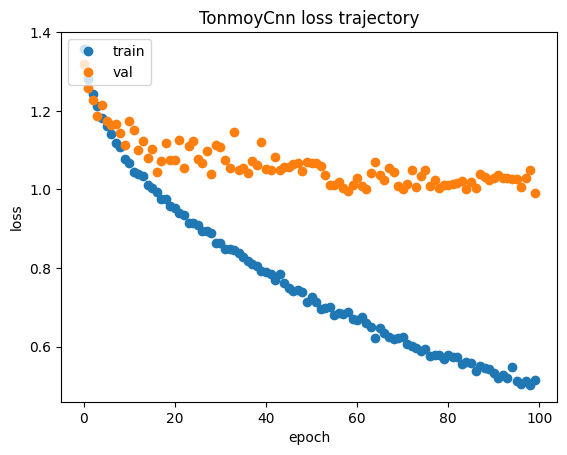

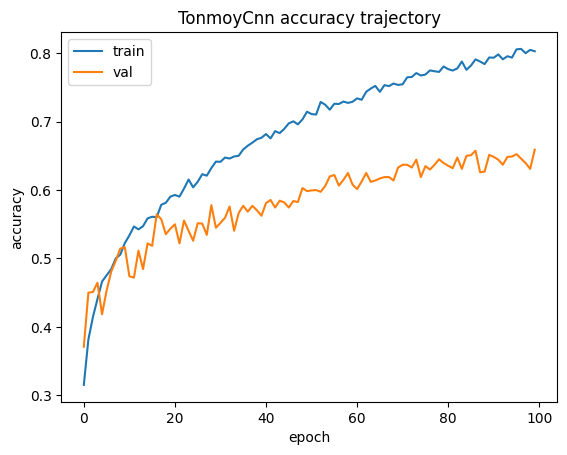

In [113]:
# Plot loss
plt.plot(train_lossv,'o')
plt.plot(val_lossv,'o')
plt.title('TonmoyCnnLstm loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot accuracy
plt.plot(train_accv)
plt.plot(val_accv)
plt.title('TonmoyCnnLstm accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test model

In [114]:
num_classes = 4

def test():
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the test set
    test_correct_count_per_class = np.zeros(4) # no. of correctly classified examples for each class (idx is class_id)
    test_count_per_class = np.zeros(4) # no. of examples for each class (idx is class_id)
    test_correct_count = 0
    with torch.no_grad(): # speed things up because we kn
        for X_batch, y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            test_correct_count += torch.sum(y_hat_batch == y_batch, dim=-1) # accumulate no. of correctly classified examples

            correct_idxs = (y_hat_batch == y_batch)
            for cls in range(num_classes):
                test_count_per_class[cls] += torch.sum(y_batch == cls) # accumulate no. of examples per class
                test_correct_count_per_class[cls] += torch.sum(y_batch[correct_idxs] == cls) # accumulate no. of correctly classified examples per class
                

    accuracy = test_correct_count / len(test_dataloader.dataset)
    # accuracies_per_class = {class_id: acc for class_id, acc in zip(range(num_classes), test_correct_count_per_class/test_count_per_class)}
    accuracies_per_class = test_correct_count_per_class/test_count_per_class

    return accuracy, accuracies_per_class

accuracy, accuracies_per_class = test()
print(f"Total Accuracy: {accuracy}")
for c, acc in enumerate(accuracies_per_class):
    print(f"    - Accuracy for class {c}: {acc}")

Total Accuracy: 0.5801354401805869
    - Accuracy for class 0: 0.6396396396396397
    - Accuracy for class 1: 0.5275590551181102
    - Accuracy for class 2: 0.5416666666666666
    - Accuracy for class 3: 0.6146788990825688


# Model (CNN)

## Create model

In [306]:
class Cnn(nn.Module):
    """ A CNN model """
    def __init__(self):
        super(Cnn, self).__init__()

        # Declare some fixed parameters
        num_in_channels = 22
        num_output_classes = 4
        num_filters_c1 = 50
        num_filters_c2 = 50
        num_filters_c3 = 100
        num_filters_c4 = 100
        num_filters_c5 = 50
        num_filters_c6 = 50
        num_filters_c7 = 150
        num_filters_c8 = 150
        num_filters_c9 = 150
        num_filters_c10 = 200
        num_filters_c11 = 200
        num_filters_c12 = 200

        # Declare layers
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(in_channels=num_in_channels, out_channels=num_filters_c1, kernel_size=(5,1), padding="same"),
            nn.ELU(),
        )

        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c1, out_channels=num_filters_c2, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c2),
            nn.Dropout(p=0.75)
        )

        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c2, out_channels=num_filters_c3, kernel_size=(5,1), padding="same"),
            nn.ELU(),
        )

        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c3, out_channels=num_filters_c4, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c4),
            nn.Dropout(p=0.75)
        )

        # self.ConvLayer5 = nn.Sequential(
        #     nn.Conv2d(in_channels=num_filters_c4, out_channels=num_filters_c5, kernel_size=(5,1), padding="same"),
        #     nn.ELU(),
        # )

        # self.ConvLayer6 = nn.Sequential(
        #     nn.Conv2d(in_channels=num_filters_c5, out_channels=num_filters_c6, kernel_size=(5,1), padding="same"),
        #     nn.ELU(),
        #     nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
        #     nn.BatchNorm2d(num_features=num_filters_c6),
        #     nn.Dropout(p=0.5)
        # )

        self.ConvLayer7 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c4, out_channels=num_filters_c7, kernel_size=(5,1), padding="same"),
            nn.ELU(),
        )

        self.ConvLayer8 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c7, out_channels=num_filters_c8, kernel_size=(5,1), padding="same"),
            nn.ELU(),
        )

        self.ConvLayer9 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c8, out_channels=num_filters_c9, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c9),
            nn.Dropout(p=0.75)
        )

        # self.ConvLayer10 = nn.Sequential(
        #     nn.Conv2d(in_channels=num_filters_c9, out_channels=num_filters_c10, kernel_size=(5,1), padding="same"),
        #     nn.ELU(),
        # )

        # self.ConvLayer11 = nn.Sequential(
        #     nn.Conv2d(in_channels=num_filters_c10, out_channels=num_filters_c11, kernel_size=(5,1), padding="same"),
        #     nn.ELU(),
        # )

        # self.ConvLayer12 = nn.Sequential(
        #     nn.Conv2d(in_channels=num_filters_c11, out_channels=num_filters_c12, kernel_size=(5,1), padding="same"),
        #     nn.ELU(),
        #     nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
        #     nn.BatchNorm2d(num_features=num_filters_c12),
        #     nn.Dropout(p=0.5)
        # )

        self.FCLayer = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_output_classes)
        )

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        # x = self.ConvLayer5(x)
        # x = self.ConvLayer6(x)
        x = self.ConvLayer7(x)
        x = self.ConvLayer8(x)
        x = self.ConvLayer9(x)
        # x = self.ConvLayer10(x)
        # x = self.ConvLayer11(x)
        # x = self.ConvLayer12(x)
        x = self.FCLayer(x)
        return x

In [307]:
# Create and verify model

## Instantiate model
model = Cnn().to(device)
print("###########################")
print("#    Layer Parameters     #")
print("###########################")
print()
print(model)
print()

## Test model on dummy data
batch_size = 10
num_chans, height, width = 22, 400, 1  # input dimensions
test_input = torch.randn(batch_size, num_chans, height, width).to(device)
print("###########################")
print("#         Logits          #")
print("###########################")
print()
print(model(test_input).shape)  # should be (batch_size, num_classes) - contains the raw logits(scores) per class for each batch
print()

# Print summary of model 
print("###########################")
print("#      Model Summary      #")
print("###########################")
print()
summary(Cnn().float(), input_size=(22,400,1)) # note: torchsummary uses float32 as the input dtype

###########################
#    Layer Parameters     #
###########################

Cnn(
  (ConvLayer1): Sequential(
    (0): Conv2d(22, 50, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(50, 50, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.75, inplace=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(100, 100, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, trac

In [308]:
loss_fn = nn.CrossEntropyLoss() # declare loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1.5e-3, weight_decay=1e-3) # declare optimization method

## Train model

In [309]:
# Create datasets with any desired augmentations

## Define augmentations

class TrimTimeSteps(object):
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, X):
        return X[:,:,0:self.output_size,:]
        

class MaxPool(object):
    def __init__(self, pool_height):
        self.height = pool_height

    def __call__(self, X):
        return torch.max(X.reshape(X.shape[0], X.shape[1], -1, self.height, X.shape[3]), dim=3).values

class AvgPlusNoise(object):
    def __init__(self, pool_height):
        self.height = pool_height

    def __call__(self, X):
        X_avg = torch.mean(X.reshape(X.shape[0], X.shape[1], -1, self.height, X.shape[3]), dim=3)
        return X_avg + torch.normal(0.0, 0.5, X_avg.shape)

class Subsample(object):
    def __init__(self, step, with_noise):
        self.step = step
        self.with_noise = with_noise

    def __call__(self, X):
        X_sub_total = None
        for i in range(self.step):
            X_sub = X[:, :, i::self.step, :] # subsample every self.step time step of X starting with index i
            if self.with_noise:
                X_sub += torch.normal(0.0, 0.5, X_sub.shape) # optionally add noise
                
            # add to list of subsampled data
            if X_sub_total == None:
                X_sub_total = X_sub
            else:
                X_sub_total = torch.vstack((X_sub_total, X_sub))
            
        return X_sub_total

class HDup(object):
    def __init__(self, n):
        self.n = n  # number of samples that will be stacked

    def __call__(self, sample):
        return torch.hstack(tuple(sample for _ in range(self.n)))

## Create training and validation datasets

### Trim
tsfrm_trim = TrimTimeSteps(400)

train_ds_trim = EEGDataset(type="train", transform_data=tsfrm_trim)
val_ds_trim = EEGDataset(type="val", transform_data=tsfrm_trim)

### Max
tsfrm_max = transforms.Compose([
        TrimTimeSteps(800),
        MaxPool(2)
    ])

train_ds_max = EEGDataset(type="train", transform_data=tsfrm_max)
val_ds_max = EEGDataset(type="val", transform_data=tsfrm_max)

### Average + noise
tsfrm_avg = transforms.Compose([
        TrimTimeSteps(800),
        AvgPlusNoise(2)
    ])

train_ds_avg = EEGDataset(type="train", transform_data=tsfrm_avg)
val_ds_avg = EEGDataset(type="val", transform_data=tsfrm_avg)

### Subsample
tsfrm_subsample = transforms.Compose([
        TrimTimeSteps(800),
        Subsample(2, with_noise=True)
    ])

tsfrm_dup = HDup(2)

train_ds_subsample = EEGDataset(type="train", transform_data=tsfrm_subsample, transform_labels=tsfrm_dup)
val_ds_subsample = EEGDataset(type="val", transform_data=tsfrm_subsample, transform_labels=tsfrm_dup)

#### Concat. augmented datasets
training_dataset = torch.utils.data.ConcatDataset([
        train_ds_trim,
        train_ds_max,
        train_ds_avg,
        train_ds_subsample
    ])

validation_dataset = torch.utils.data.ConcatDataset([
        val_ds_trim,
        val_ds_max,
        val_ds_avg,
        val_ds_subsample
    ])

## Create test dataset (we need to apply an operation to reshape to match augmented data)
##   - note: do not concat. the same test data even if it's augmented differently b/c there is still correlation
##     - thus, we only apply one operation
test_dataset = EEGDataset(type="test", transform_data=tsfrm_max)

print(f"Length of new training data: {len(training_dataset)}")
print(f"Length of new validation data: {len(validation_dataset)}")
print(f"Length of new test data: {len(test_dataset)}")
print()
print(f"Shape of new training data: {training_dataset[0][0].shape}")
print(f"Shape of new validation data: {validation_dataset[0][0].shape}")
print(f"Shape of new test data: {test_dataset[0][0].shape}")


## Create pytorch dataloaders
bsz = 100
training_dataloader = DataLoader(dataset=training_dataset, batch_size=bsz, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=bsz, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=bsz, shuffle=False)

Length of new training data: 8075
Length of new validation data: 2500
Length of new test data: 443

Shape of new training data: torch.Size([22, 400, 1])
Shape of new validation data: torch.Size([22, 400, 1])
Shape of new test data: torch.Size([22, 400, 1])


In [310]:
# Create training loop
def train(loss_vector, accuracy_vector):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    train_loss, train_correct_count = 0, 0
    for batch_idx, (X_batch, y_batch) in enumerate(training_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad() # zero out the gradient buffers
        logits = model(X_batch) # pass data through the network and acquire output
        loss = loss_fn(logits, y_batch) # calculate loss
        loss.backward() # backpropogate
        optimizer.step() # update weights

        # Calculate accuracy
        with torch.no_grad():
            train_loss += loss.data.item()
            y_hat_batch = torch.argmax(logits, dim=-1) # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            train_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    # Store loss and accuracy
    loss_vector.append(train_loss/len(training_dataloader))
    accuracy_vector.append(train_correct_count/len(training_dataloader.dataset))

# Create validation loop
def validate(loss_vector, accuracy_vector):
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the validation set
    val_loss, val_correct_count = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in validation_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            val_loss += loss_fn(logits, y_batch).data.item() # calculate loss
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            val_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    # Store loss and accuracy
    loss_vector.append(val_loss/len(validation_dataloader))
    accuracy_vector.append(val_correct_count/len(validation_dataloader.dataset))

In [311]:
%%time
from time import time

epochs = 50

train_lossv, train_accv = [], []
val_lossv, val_accv = [], []
for epoch in range(1, epochs + 1):
    epoch_start = time()
    train(train_lossv, train_accv)
    validate(val_lossv, val_accv)
    print(f"Epoch {epoch}/{epochs} ({(time() - epoch_start):.2f}s) - train loss: {train_lossv[-1]} - train acc: {train_accv[-1]} - val loss: {val_lossv[-1]} - val acc: {val_accv[-1]}")
    print()

Epoch 1/50 (38.26s) - train loss: 1.7344137374355744 - train acc: 0.2917647058823529 - val loss: 1.5576017446131758 - val acc: 0.28

Epoch 2/50 (40.50s) - train loss: 1.6015397341684596 - train acc: 0.3160371517027864 - val loss: 1.3972993923357708 - val acc: 0.3132

Epoch 3/50 (41.34s) - train loss: 1.4765814363883225 - train acc: 0.36990712074303406 - val loss: 1.2684756412957952 - val acc: 0.4324

Epoch 4/50 (42.05s) - train loss: 1.4137440179240426 - train acc: 0.3993808049535604 - val loss: 1.196774164456909 - val acc: 0.4624

Epoch 5/50 (41.60s) - train loss: 1.3440351298069795 - train acc: 0.4215479876160991 - val loss: 1.1974657144557823 - val acc: 0.4784

Epoch 6/50 (42.59s) - train loss: 1.2654300044626614 - train acc: 0.46154798761609905 - val loss: 1.1969216472069286 - val acc: 0.4648

Epoch 7/50 (42.21s) - train loss: 1.2166709002729443 - train acc: 0.4852012383900929 - val loss: 1.0787545317784273 - val acc: 0.5416

Epoch 8/50 (42.09s) - train loss: 1.1911504210620327 - t

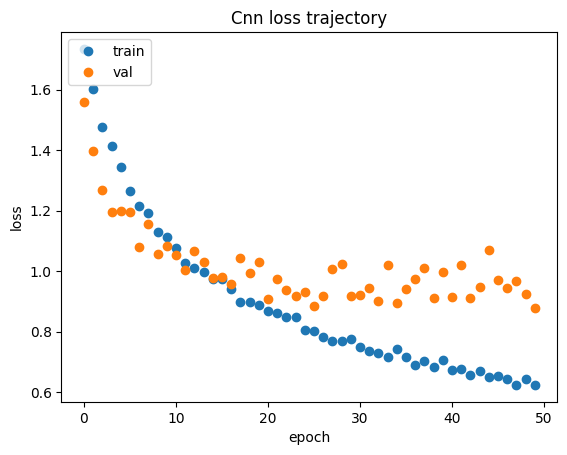

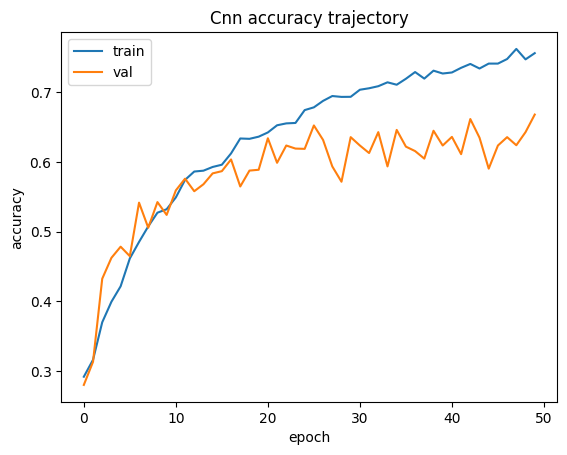

In [312]:
# Plot loss
plt.plot(train_lossv,'o')
plt.plot(val_lossv,'o')
plt.title('Cnn loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot accuracy
plt.plot(train_accv)
plt.plot(val_accv)
plt.title('Cnn accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test model

In [313]:
num_classes = 4

def test():
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the test set
    test_correct_count_per_class = np.zeros(4) # no. of correctly classified examples for each class (idx is class_id)
    test_count_per_class = np.zeros(4) # no. of examples for each class (idx is class_id)
    test_correct_count = 0
    with torch.no_grad(): # speed things up because we kn
        for X_batch, y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            test_correct_count += torch.sum(y_hat_batch == y_batch, dim=-1) # accumulate no. of correctly classified examples

            correct_idxs = (y_hat_batch == y_batch)
            for cls in range(num_classes):
                test_count_per_class[cls] += torch.sum(y_batch == cls) # accumulate no. of examples per class
                test_correct_count_per_class[cls] += torch.sum(y_batch[correct_idxs] == cls) # accumulate no. of correctly classified examples per class
                

    accuracy = test_correct_count / len(test_dataloader.dataset)
    # accuracies_per_class = {class_id: acc for class_id, acc in zip(range(num_classes), test_correct_count_per_class/test_count_per_class)}
    accuracies_per_class = test_correct_count_per_class/test_count_per_class

    return accuracy, accuracies_per_class

accuracy, accuracies_per_class = test()
print(f"Total Accuracy: {accuracy}")
for c, acc in enumerate(accuracies_per_class):
    print(f"    - Accuracy for class {c}: {acc}")

Total Accuracy: 0.6478555304740407
    - Accuracy for class 0: 0.7927927927927928
    - Accuracy for class 1: 0.5433070866141733
    - Accuracy for class 2: 0.4895833333333333
    - Accuracy for class 3: 0.7614678899082569


# Model (CNN + LSTM)

## Create model

In [628]:
class CnnLstm(nn.Module):
    """ A CNN + LSTM model """
    def __init__(self):
        super(CnnLstm, self).__init__()

        # Declare some fixed parameters
        self.num_in_channels = 22
        self.num_output_classes = 4
        self.num_filters_c1 = 100
        self.num_filters_c2 = 150
        self.num_filters_c3 = 150
        self.num_filters_c4 = 150
        self.lstm_hidden_size = 20

        # Declare layers
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_in_channels, out_channels=self.num_filters_c1, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=self.num_filters_c1),
            nn.Dropout(p=0.75)
        )
        
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_filters_c1, out_channels=self.num_filters_c2, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            # nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=self.num_filters_c2),
            nn.Dropout(p=0.75)
        )
        
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_filters_c2, out_channels=self.num_filters_c3, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=self.num_filters_c3),
            nn.Dropout(p=0.75)
        )
        
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_filters_c3, out_channels=self.num_filters_c4, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            # nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=self.num_filters_c4),
            nn.Dropout(p=0.75)
        )

        self.LstmLayer = nn.Sequential(
            # num_filters_c4 is interpreted by the lstm as time steps
            nn.LSTM(input_size=45, hidden_size=self.lstm_hidden_size, dropout=0.5, batch_first=True, bidirectional=False)
        )

        self.FcLayer = nn.Sequential(
            nn.LazyLinear(self.num_output_classes)
        )

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        # print(x.shape)
        x = x.view(-1, self.num_filters_c4, 45) # reshape to (batch_size, time_steps, input_size) that the lstm expects
        # x = self.LstmLayer(x)[1][0] # hidden state at the output of the *last* time step
        x = self.LstmLayer(x)[0] # hidden state at the output all time step
        # print(x.shape)
        # x = x.reshape(-1, 10) # (1, N, H) -> (N, H)
        x = x.reshape(-1, self.num_filters_c4 * self.lstm_hidden_size) # (1, N, H) -> (N, H)
        x = self.FcLayer(x)
        return x

In [629]:
# Create and verify model

## Instantiate model
model = CnnLstm().to(device)
print("###########################")
print("#    Layer Parameters     #")
print("###########################")
print()
print(model)
print()

## Test model on dummy data
batch_size = 10
num_chans, height, width = 22, 400, 1  # input dimensions
test_input = torch.randn(batch_size, num_chans, height, width).to(device)
print("###########################")
print("#         Logits          #")
print("###########################")
print()
print(model(test_input).shape)  # should be (batch_size, num_classes) - contains the raw logits(scores) per class for each batch
print()

# Print summary of model 
# print("###########################")
# print("#      Model Summary      #")
# print("###########################")
# print()
# summary(CnnLstm().float(), input_size=(22,400,1)) # note: torchsummary uses float32 as the input dtype

###########################
#    Layer Parameters     #
###########################

CnnLstm(
  (ConvLayer1): Sequential(
    (0): Conv2d(22, 100, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.75, inplace=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(100, 150, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.75, inplace=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(150, 150, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=Tr

In [630]:
loss_fn = nn.CrossEntropyLoss() # declare loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1.5e-3, weight_decay=1e-5) # declare optimization method
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=7)

## Train model

In [631]:
# Create datasets with any desired augmentations

## Define augmentations

class TrimTimeSteps(object):
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, X):
        return X[:,:,0:self.output_size,:]
        

class MaxPool(object):
    def __init__(self, pool_height):
        self.height = pool_height

    def __call__(self, X):
        return torch.max(X.reshape(X.shape[0], X.shape[1], -1, self.height, X.shape[3]), dim=3).values

class AvgPlusNoise(object):
    def __init__(self, pool_height):
        self.height = pool_height

    def __call__(self, X):
        X_avg = torch.mean(X.reshape(X.shape[0], X.shape[1], -1, self.height, X.shape[3]), dim=3)
        return X_avg + torch.normal(0.0, 0.5, X_avg.shape)

class Subsample(object):
    def __init__(self, step, with_noise):
        self.step = step
        self.with_noise = with_noise

    def __call__(self, X):
        X_sub_total = None
        for i in range(self.step):
            X_sub = X[:, :, i::self.step, :] # subsample every self.step time step of X starting with index i
            if self.with_noise:
                X_sub += torch.normal(0.0, 0.5, X_sub.shape) # optionally add noise
                
            # add to list of subsampled data
            if X_sub_total == None:
                X_sub_total = X_sub
            else:
                X_sub_total = torch.vstack((X_sub_total, X_sub))
            
        return X_sub_total

class HDup(object):
    def __init__(self, n):
        self.n = n  # number of samples that will be stacked

    def __call__(self, sample):
        return torch.hstack(tuple(sample for _ in range(self.n)))

## Create training and validation datasets

### Trim
tsfrm_trim = TrimTimeSteps(400)

train_ds_trim = EEGDataset(type="train", transform_data=tsfrm_trim)
val_ds_trim = EEGDataset(type="val", transform_data=tsfrm_trim)

### Max
tsfrm_max = transforms.Compose([
        TrimTimeSteps(800),
        MaxPool(2)
    ])

train_ds_max = EEGDataset(type="train", transform_data=tsfrm_max)
val_ds_max = EEGDataset(type="val", transform_data=tsfrm_max)

### Average + noise
tsfrm_avg = transforms.Compose([
        TrimTimeSteps(800),
        AvgPlusNoise(2)
    ])

train_ds_avg = EEGDataset(type="train", transform_data=tsfrm_avg)
val_ds_avg = EEGDataset(type="val", transform_data=tsfrm_avg)

### Subsample
tsfrm_subsample = transforms.Compose([
        TrimTimeSteps(800),
        Subsample(2, with_noise=True)
    ])

tsfrm_dup = HDup(2)

train_ds_subsample = EEGDataset(type="train", transform_data=tsfrm_subsample, transform_labels=tsfrm_dup)
val_ds_subsample = EEGDataset(type="val", transform_data=tsfrm_subsample, transform_labels=tsfrm_dup)

#### Concat. augmented datasets
training_dataset = torch.utils.data.ConcatDataset([
        train_ds_trim,
        train_ds_max,
        train_ds_avg,
        train_ds_subsample
    ])

validation_dataset = torch.utils.data.ConcatDataset([
        val_ds_trim,
        val_ds_max,
        val_ds_avg,
        val_ds_subsample
    ])

## Create test dataset (we need to apply an operation to reshape to match augmented data)
##   - note: do not concat. the same test data even if it's augmented differently b/c there is still correlation
##     - thus, we only apply one operation
test_dataset = EEGDataset(type="test", transform_data=tsfrm_max)

print(f"Length of new training data: {len(training_dataset)}")
print(f"Length of new validation data: {len(validation_dataset)}")
print(f"Length of new test data: {len(test_dataset)}")
print()
print(f"Shape of new training data: {training_dataset[0][0].shape}")
print(f"Shape of new validation data: {validation_dataset[0][0].shape}")
print(f"Shape of new test data: {test_dataset[0][0].shape}")


## Create pytorch dataloaders
bsz = 50
training_dataloader = DataLoader(dataset=training_dataset, batch_size=bsz, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=bsz, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=bsz, shuffle=False)

Length of new training data: 8075
Length of new validation data: 2500
Length of new test data: 443

Shape of new training data: torch.Size([22, 400, 1])
Shape of new validation data: torch.Size([22, 400, 1])
Shape of new test data: torch.Size([22, 400, 1])


In [632]:
# Create training loop
def train(loss_vector, accuracy_vector):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    train_loss, train_correct_count = 0, 0
    for batch_idx, (X_batch, y_batch) in enumerate(training_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad() # zero out the gradient buffers
        logits = model(X_batch) # pass data through the network and acquire output
        loss = loss_fn(logits, y_batch) # calculate loss
        loss.backward() # backpropogate
        optimizer.step() # update weights

        # Calculate accuracy
        with torch.no_grad():
            train_loss += loss.data.item()
            y_hat_batch = torch.argmax(logits, dim=-1) # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            train_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    # Store loss and accuracy
    loss_vector.append(train_loss/len(training_dataloader))
    accuracy_vector.append(train_correct_count/len(training_dataloader.dataset))

# Create validation loop
def validate(loss_vector, accuracy_vector):
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the validation set
    val_loss, val_correct_count = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in validation_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            val_loss += loss_fn(logits, y_batch).data.item() # calculate loss
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            val_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    scheduler.step(val_loss)

    # Store loss and accuracy
    loss_vector.append(val_loss/len(validation_dataloader))
    accuracy_vector.append(val_correct_count/len(validation_dataloader.dataset))

In [ ]:
%%time
from time import time

epochs = 75

# train_lossv, train_accv = [], []
# val_lossv, val_accv = [], []
for epoch in range(1, epochs + 1):
    epoch_start = time()
    train(train_lossv, train_accv)
    validate(val_lossv, val_accv)
    print(f"Epoch {epoch}/{epochs} ({(time() - epoch_start):.2f}s) - train loss: {train_lossv[-1]:.5f} - train acc: {train_accv[-1]:.5f} - val loss: {val_lossv[-1]:.5f} - val acc: {val_accv[-1]:.5f} - lr: {scheduler.get_last_lr()}")
    print()

Epoch 1/75 (49.57s) - train loss: 1.39246 - train acc: 0.27678 - val loss: 1.41286 - val acc: 0.28600 - lr: [0.0015]

Epoch 2/75 (52.22s) - train loss: 1.36119 - train acc: 0.32954 - val loss: 1.37898 - val acc: 0.33600 - lr: [0.0015]

Epoch 3/75 (52.13s) - train loss: 1.30827 - train acc: 0.37115 - val loss: 1.29364 - val acc: 0.39240 - lr: [0.0015]

Epoch 4/75 (50.16s) - train loss: 1.26842 - train acc: 0.40557 - val loss: 1.25232 - val acc: 0.44080 - lr: [0.0015]

Epoch 5/75 (53.40s) - train loss: 1.23071 - train acc: 0.43344 - val loss: 1.22850 - val acc: 0.44520 - lr: [0.0015]

Epoch 6/75 (54.53s) - train loss: 1.21426 - train acc: 0.44062 - val loss: 1.24034 - val acc: 0.43120 - lr: [0.0015]

Epoch 7/75 (58.65s) - train loss: 1.19591 - train acc: 0.46204 - val loss: 1.20174 - val acc: 0.46760 - lr: [0.0015]

Epoch 8/75 (55.64s) - train loss: 1.17812 - train acc: 0.47146 - val loss: 1.20473 - val acc: 0.46640 - lr: [0.0015]

Epoch 9/75 (56.58s) - train loss: 1.15922 - train acc: 0

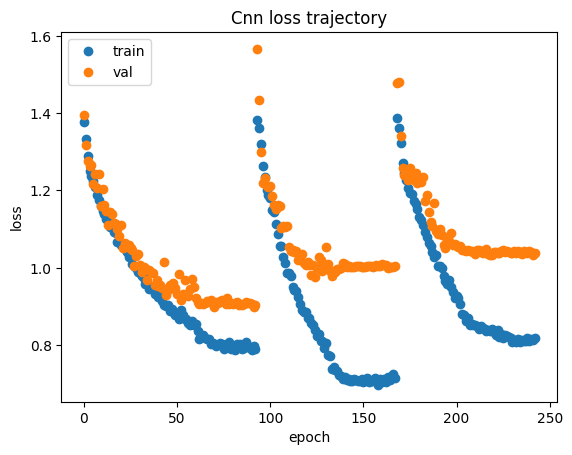

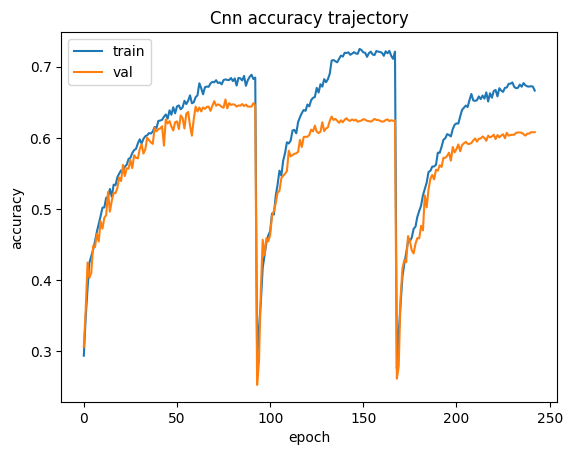

In [607]:
# Plot loss
plt.plot(train_lossv,'o')
plt.plot(val_lossv,'o')
plt.title('Cnn loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot accuracy
plt.plot(train_accv)
plt.plot(val_accv)
plt.title('Cnn accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test model

In [600]:
num_classes = 4

def test():
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the test set
    test_correct_count_per_class = np.zeros(4) # no. of correctly classified examples for each class (idx is class_id)
    test_count_per_class = np.zeros(4) # no. of examples for each class (idx is class_id)
    test_correct_count = 0
    with torch.no_grad(): # speed things up because we kn
        for X_batch, y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            test_correct_count += torch.sum(y_hat_batch == y_batch, dim=-1) # accumulate no. of correctly classified examples

            correct_idxs = (y_hat_batch == y_batch)
            for cls in range(num_classes):
                test_count_per_class[cls] += torch.sum(y_batch == cls) # accumulate no. of examples per class
                test_correct_count_per_class[cls] += torch.sum(y_batch[correct_idxs] == cls) # accumulate no. of correctly classified examples per class
                

    accuracy = test_correct_count / len(test_dataloader.dataset)
    # accuracies_per_class = {class_id: acc for class_id, acc in zip(range(num_classes), test_correct_count_per_class/test_count_per_class)}
    accuracies_per_class = test_correct_count_per_class/test_count_per_class

    return accuracy, accuracies_per_class

accuracy, accuracies_per_class = test()
print(f"Total Accuracy: {accuracy}")
for c, acc in enumerate(accuracies_per_class):
    print(f"    - Accuracy for class {c}: {acc}")

Total Accuracy: 0.6139954853273137
    - Accuracy for class 0: 0.6306306306306306
    - Accuracy for class 1: 0.6377952755905512
    - Accuracy for class 2: 0.5
    - Accuracy for class 3: 0.6697247706422018


In [405]:
num_classes = 4

def test():
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the test set
    test_correct_count_per_class = np.zeros(4) # no. of correctly classified examples for each class (idx is class_id)
    test_count_per_class = np.zeros(4) # no. of examples for each class (idx is class_id)
    test_correct_count = 0
    with torch.no_grad(): # speed things up because we kn
        for X_batch, y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            test_correct_count += torch.sum(y_hat_batch == y_batch, dim=-1) # accumulate no. of correctly classified examples

            correct_idxs = (y_hat_batch == y_batch)
            for cls in range(num_classes):
                test_count_per_class[cls] += torch.sum(y_batch == cls) # accumulate no. of examples per class
                test_correct_count_per_class[cls] += torch.sum(y_batch[correct_idxs] == cls) # accumulate no. of correctly classified examples per class
                

    accuracy = test_correct_count / len(test_dataloader.dataset)
    # accuracies_per_class = {class_id: acc for class_id, acc in zip(range(num_classes), test_correct_count_per_class/test_count_per_class)}
    accuracies_per_class = test_correct_count_per_class/test_count_per_class

    return accuracy, accuracies_per_class

accuracy, accuracies_per_class = test()
print(f"Total Accuracy: {accuracy}")
for c, acc in enumerate(accuracies_per_class):
    print(f"    - Accuracy for class {c}: {acc}")

Total Accuracy: 0.690744920993228
    - Accuracy for class 0: 0.8828828828828829
    - Accuracy for class 1: 0.7716535433070866
    - Accuracy for class 2: 0.59375
    - Accuracy for class 3: 0.48623853211009177


# Model (BrittneyCNN)

## Create model

In [917]:
class BrittneyCnn(nn.Module):
    """ A CNN model """
    def __init__(self):
        super(BrittneyCnn, self).__init__()

        # Declare some fixed parameters
        num_in_channels = 22
        num_output_classes = 4
        num_filters_c1 = 15
        num_filters_c2 = 25
        num_filters_c3 = 75
        num_filters_c4 = 90

        # Declare layers
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(in_channels=num_in_channels, out_channels=num_filters_c1, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c1),
            nn.Dropout(p=0.32)
        )

        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c1, out_channels=num_filters_c2, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c2),
            nn.Dropout(p=0.4)
        )

        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c2, out_channels=num_filters_c3, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c3),
            nn.Dropout(p=0.32)
        )

        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters_c3, out_channels=num_filters_c4, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=num_filters_c4),
            nn.Dropout(p=0.4)
        )
        
        self.FCLayer = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_output_classes)
        )

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = self.FCLayer(x)
        return x

In [890]:
# Create and verify model

## Instantiate model
model = BrittneyCnn().to(device)
print("###########################")
print("#    Layer Parameters     #")
print("###########################")
print()
print(model)
print()

## Test model on dummy data
batch_size = 10
num_chans, height, width = 22, 800, 1  # input dimensions
test_input = torch.randn(batch_size, num_chans, height, width).to(device)
print("###########################")
print("#         Logits          #")
print("###########################")
print()
print(model(test_input).shape)  # should be (batch_size, num_classes) - contains the raw logits(scores) per class for each batch
print()

# Print summary of model 
print("###########################")
print("#      Model Summary      #")
print("###########################")
print()
summary(BrittneyCnn().float(), input_size=(22,800,1)) # note: torchsummary uses float32 as the input dtype

###########################
#    Layer Parameters     #
###########################

BrittneyCnn(
  (ConvLayer1): Sequential(
    (0): Conv2d(22, 15, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.32, inplace=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(15, 25, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(25, 75, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1

In [891]:
loss_fn = nn.CrossEntropyLoss() # declare loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2) # declare optimization method
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=7)

## Train model

In [892]:
# Create datasets with any desired augmentations

## Define augmentations

class TrimTimeSteps(object):
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, X):
        return X[:,:,0:self.output_size,:]

class MaxPool(object):
    def __init__(self, pool_height):
        self.height = pool_height

    def __call__(self, X):
        return torch.max(X.reshape(X.shape[0], X.shape[1], -1, self.height, X.shape[3]), dim=3).values

class AvgPlusNoise(object):
    def __init__(self, pool_height):
        self.height = pool_height

    def __call__(self, X):
        X_avg = torch.mean(X.reshape(X.shape[0], X.shape[1], -1, self.height, X.shape[3]), dim=3)
        return X_avg + torch.normal(0.0, 0.5, X_avg.shape)
        
tsfrm_trim = TrimTimeSteps(800)
train_ds_trim = EEGDataset(type="train", transform_data=tsfrm_trim)
val_ds_trim = EEGDataset(type="val", transform_data=tsfrm_trim)

tsfrm_max = MaxPool(2)
train_ds_max = EEGDataset(type="train", transform_data=tsfrm_max)
val_ds_max = EEGDataset(type="val", transform_data=tsfrm_max)

training_dataset = torch.utils.data.ConcatDataset([
        train_ds_trim,
        # train_ds_max
    ])

validation_dataset = torch.utils.data.ConcatDataset([
        val_ds_trim,
        # val_ds_max
    ])

test_dataset = EEGDataset(type="test", transform_data=tsfrm_trim)

print(f"Length of new training data: {len(training_dataset)}")
print(f"Length of new validation data: {len(validation_dataset)}")
print(f"Length of new test data: {len(test_dataset)}")
print()
print(f"Shape of new training data: {training_dataset[0][0].shape}")
print(f"Shape of new validation data: {validation_dataset[0][0].shape}")
print(f"Shape of new test data: {test_dataset[0][0].shape}")


## Create pytorch dataloaders
bsz = 64
training_dataloader = DataLoader(dataset=training_dataset, batch_size=bsz, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=bsz, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=bsz, shuffle=False)

Length of new training data: 1615
Length of new validation data: 500
Length of new test data: 443

Shape of new training data: torch.Size([22, 800, 1])
Shape of new validation data: torch.Size([22, 800, 1])
Shape of new test data: torch.Size([22, 800, 1])


In [918]:
# Create training loop
def train(loss_vector, accuracy_vector):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    train_loss, train_correct_count = 0, 0
    for batch_idx, (X_batch, y_batch) in enumerate(training_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad() # zero out the gradient buffers
        logits = model(X_batch) # pass data through the network and acquire output
        loss = loss_fn(logits, y_batch) # calculate loss
        l1_norm = torch.norm(model.FCLayer[1].weight, p=1)
        loss += l1_norm * 0.01
        loss.backward() # backpropogate
        optimizer.step() # update weights

        # Calculate accuracy
        with torch.no_grad():
            train_loss += loss.data.item()
            y_hat_batch = torch.argmax(logits, dim=-1) # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            train_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    # Store loss and accuracy
    loss_vector.append(train_loss/len(training_dataloader))
    accuracy_vector.append(train_correct_count/len(training_dataloader.dataset))

# Create validation loop
def validate(loss_vector, accuracy_vector):
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the validation set
    val_loss, val_correct_count = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in validation_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            val_loss += loss_fn(logits, y_batch).data.item() # calculate loss
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            val_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    scheduler.step(val_loss)
    
    # Store loss and accuracy
    loss_vector.append(val_loss/len(validation_dataloader))
    accuracy_vector.append(val_correct_count/len(validation_dataloader.dataset))

In [894]:
%%time
from time import time

epochs = 100

train_lossv, train_accv = [], []
val_lossv, val_accv = [], []
for epoch in range(1, epochs + 1):
    epoch_start = time()
    train(train_lossv, train_accv)
    validate(val_lossv, val_accv)
    print(f"Epoch {epoch}/{epochs} ({(time() - epoch_start):.2f}s) - train loss: {train_lossv[-1]:.5f} - train acc: {train_accv[-1]:.5f} - val loss: {val_lossv[-1]:.5f} - val acc: {val_accv[-1]:.5f} - lr: {scheduler.get_last_lr()}")
    print()

Epoch 1/100 (2.57s) - train loss: 2.01924 - train acc: 0.31269 - val loss: 1.44444 - val acc: 0.24400 - lr: [0.001]

Epoch 2/100 (2.73s) - train loss: 1.80249 - train acc: 0.32755 - val loss: 1.44073 - val acc: 0.29400 - lr: [0.001]

Epoch 3/100 (2.47s) - train loss: 1.63812 - train acc: 0.38514 - val loss: 1.34782 - val acc: 0.34600 - lr: [0.001]

Epoch 4/100 (2.49s) - train loss: 1.50525 - train acc: 0.42972 - val loss: 1.33597 - val acc: 0.35600 - lr: [0.001]

Epoch 5/100 (2.54s) - train loss: 1.45192 - train acc: 0.44025 - val loss: 1.38691 - val acc: 0.34000 - lr: [0.001]

Epoch 6/100 (2.27s) - train loss: 1.39867 - train acc: 0.46006 - val loss: 1.30515 - val acc: 0.36000 - lr: [0.001]

Epoch 7/100 (2.59s) - train loss: 1.35079 - train acc: 0.48359 - val loss: 1.28047 - val acc: 0.41000 - lr: [0.001]

Epoch 8/100 (2.41s) - train loss: 1.32600 - train acc: 0.49040 - val loss: 1.19745 - val acc: 0.46200 - lr: [0.001]

Epoch 9/100 (2.33s) - train loss: 1.29296 - train acc: 0.51950 -

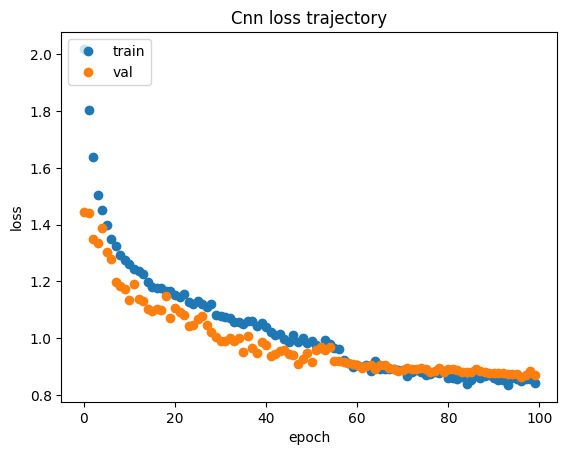

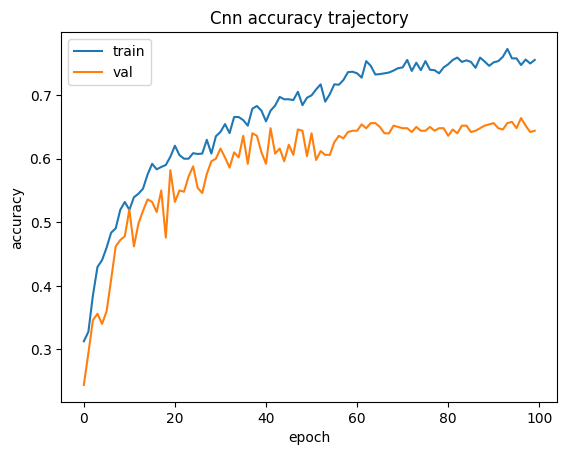

In [895]:
# Plot loss
plt.plot(train_lossv,'o')
plt.plot(val_lossv,'o')
plt.title('Cnn loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot accuracy
plt.plot(train_accv)
plt.plot(val_accv)
plt.title('Cnn accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test model

In [896]:
num_classes = 4

def test():
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the test set
    test_correct_count_per_class = np.zeros(4) # no. of correctly classified examples for each class (idx is class_id)
    test_count_per_class = np.zeros(4) # no. of examples for each class (idx is class_id)
    test_correct_count = 0
    with torch.no_grad(): # speed things up because we kn
        for X_batch, y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            test_correct_count += torch.sum(y_hat_batch == y_batch, dim=-1) # accumulate no. of correctly classified examples

            correct_idxs = (y_hat_batch == y_batch)
            for cls in range(num_classes):
                test_count_per_class[cls] += torch.sum(y_batch == cls) # accumulate no. of examples per class
                test_correct_count_per_class[cls] += torch.sum(y_batch[correct_idxs] == cls) # accumulate no. of correctly classified examples per class
                

    accuracy = test_correct_count / len(test_dataloader.dataset)
    # accuracies_per_class = {class_id: acc for class_id, acc in zip(range(num_classes), test_correct_count_per_class/test_count_per_class)}
    accuracies_per_class = test_correct_count_per_class/test_count_per_class

    return accuracy, accuracies_per_class

accuracy, accuracies_per_class = test()
print(f"Total Accuracy: {accuracy}")
for c, acc in enumerate(accuracies_per_class):
    print(f"    - Accuracy for class {c}: {acc}")

Total Accuracy: 0.6523702031602708
    - Accuracy for class 0: 0.7567567567567568
    - Accuracy for class 1: 0.5354330708661418
    - Accuracy for class 2: 0.6979166666666666
    - Accuracy for class 3: 0.6422018348623854


## Test Time Steps

In [925]:
# Create datasets with any desired augmentations

## Define augmentations

class TrimTimeSteps(object):
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, X):
        return X[:,:,0:self.output_size,:]

time_steps = [200, 400, 600, 800, 1000]
models = {}

for time_step in time_steps:
    tsfrm = TrimTimeSteps(time_step)
    training_dataset = EEGDataset(type="train", transform_data=tsfrm)
    validation_dataset = EEGDataset(type="val", transform_data=tsfrm)
    test_dataset = EEGDataset(type="test", transform_data=tsfrm)
    
    bsz = 64
    training_dataloader = DataLoader(dataset=training_dataset, batch_size=bsz, shuffle=True)
    validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=bsz, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=bsz, shuffle=False)

    model = BrittneyCnn().to(device)
    loss_fn = nn.CrossEntropyLoss() # declare loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2) # declare optimization method
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=7)

    epochs = 75
    
    train_lossv, train_accv = [], []
    val_lossv, val_accv = [], []
    print(f"Time Steps: {time_step}")
    for epoch in range(1, epochs + 1):
        epoch_start = time()
        train(train_lossv, train_accv)
        validate(val_lossv, val_accv)
        print(f"Epoch {epoch}/{epochs} ({(time() - epoch_start):.2f}s) - train loss: {train_lossv[-1]:.5f} - train acc: {train_accv[-1]:.5f} - val loss: {val_lossv[-1]:.5f} - val acc: {val_accv[-1]:.5f} - lr: {scheduler.get_last_lr()}")
        print()
        
    models[time_step] = {"train_lossv": train_lossv, "train_accv": train_accv, "val_lossv": val_lossv, "val_accv": val_accv}

    accuracy, accuracies_per_class = test()
    
    print(f"Total Accuracy: {accuracy}")
    for c, acc in enumerate(accuracies_per_class):
        print(f"    - Accuracy for class {c}: {acc}")

    models[time_step]["test_accuracy"] = accuracy
    models[time_step]["test_accuracies_per_class"] = accuracies_per_class

Time Steps: 200
Epoch 1/75 (1.19s) - train loss: 1.78355 - train acc: 0.30588 - val loss: 1.33852 - val acc: 0.35200 - lr: [0.001]

Epoch 2/75 (0.90s) - train loss: 1.65326 - train acc: 0.32941 - val loss: 1.33572 - val acc: 0.36400 - lr: [0.001]

Epoch 3/75 (0.89s) - train loss: 1.53997 - train acc: 0.35480 - val loss: 1.32493 - val acc: 0.40000 - lr: [0.001]

Epoch 4/75 (1.13s) - train loss: 1.48518 - train acc: 0.38514 - val loss: 1.33895 - val acc: 0.36200 - lr: [0.001]

Epoch 5/75 (0.90s) - train loss: 1.44300 - train acc: 0.37709 - val loss: 1.28744 - val acc: 0.41400 - lr: [0.001]

Epoch 6/75 (0.86s) - train loss: 1.40398 - train acc: 0.40557 - val loss: 1.29155 - val acc: 0.40600 - lr: [0.001]

Epoch 7/75 (0.89s) - train loss: 1.36031 - train acc: 0.43653 - val loss: 1.26756 - val acc: 0.42600 - lr: [0.001]

Epoch 8/75 (0.88s) - train loss: 1.33146 - train acc: 0.45697 - val loss: 1.26668 - val acc: 0.41000 - lr: [0.001]

Epoch 9/75 (0.83s) - train loss: 1.30420 - train acc: 0.

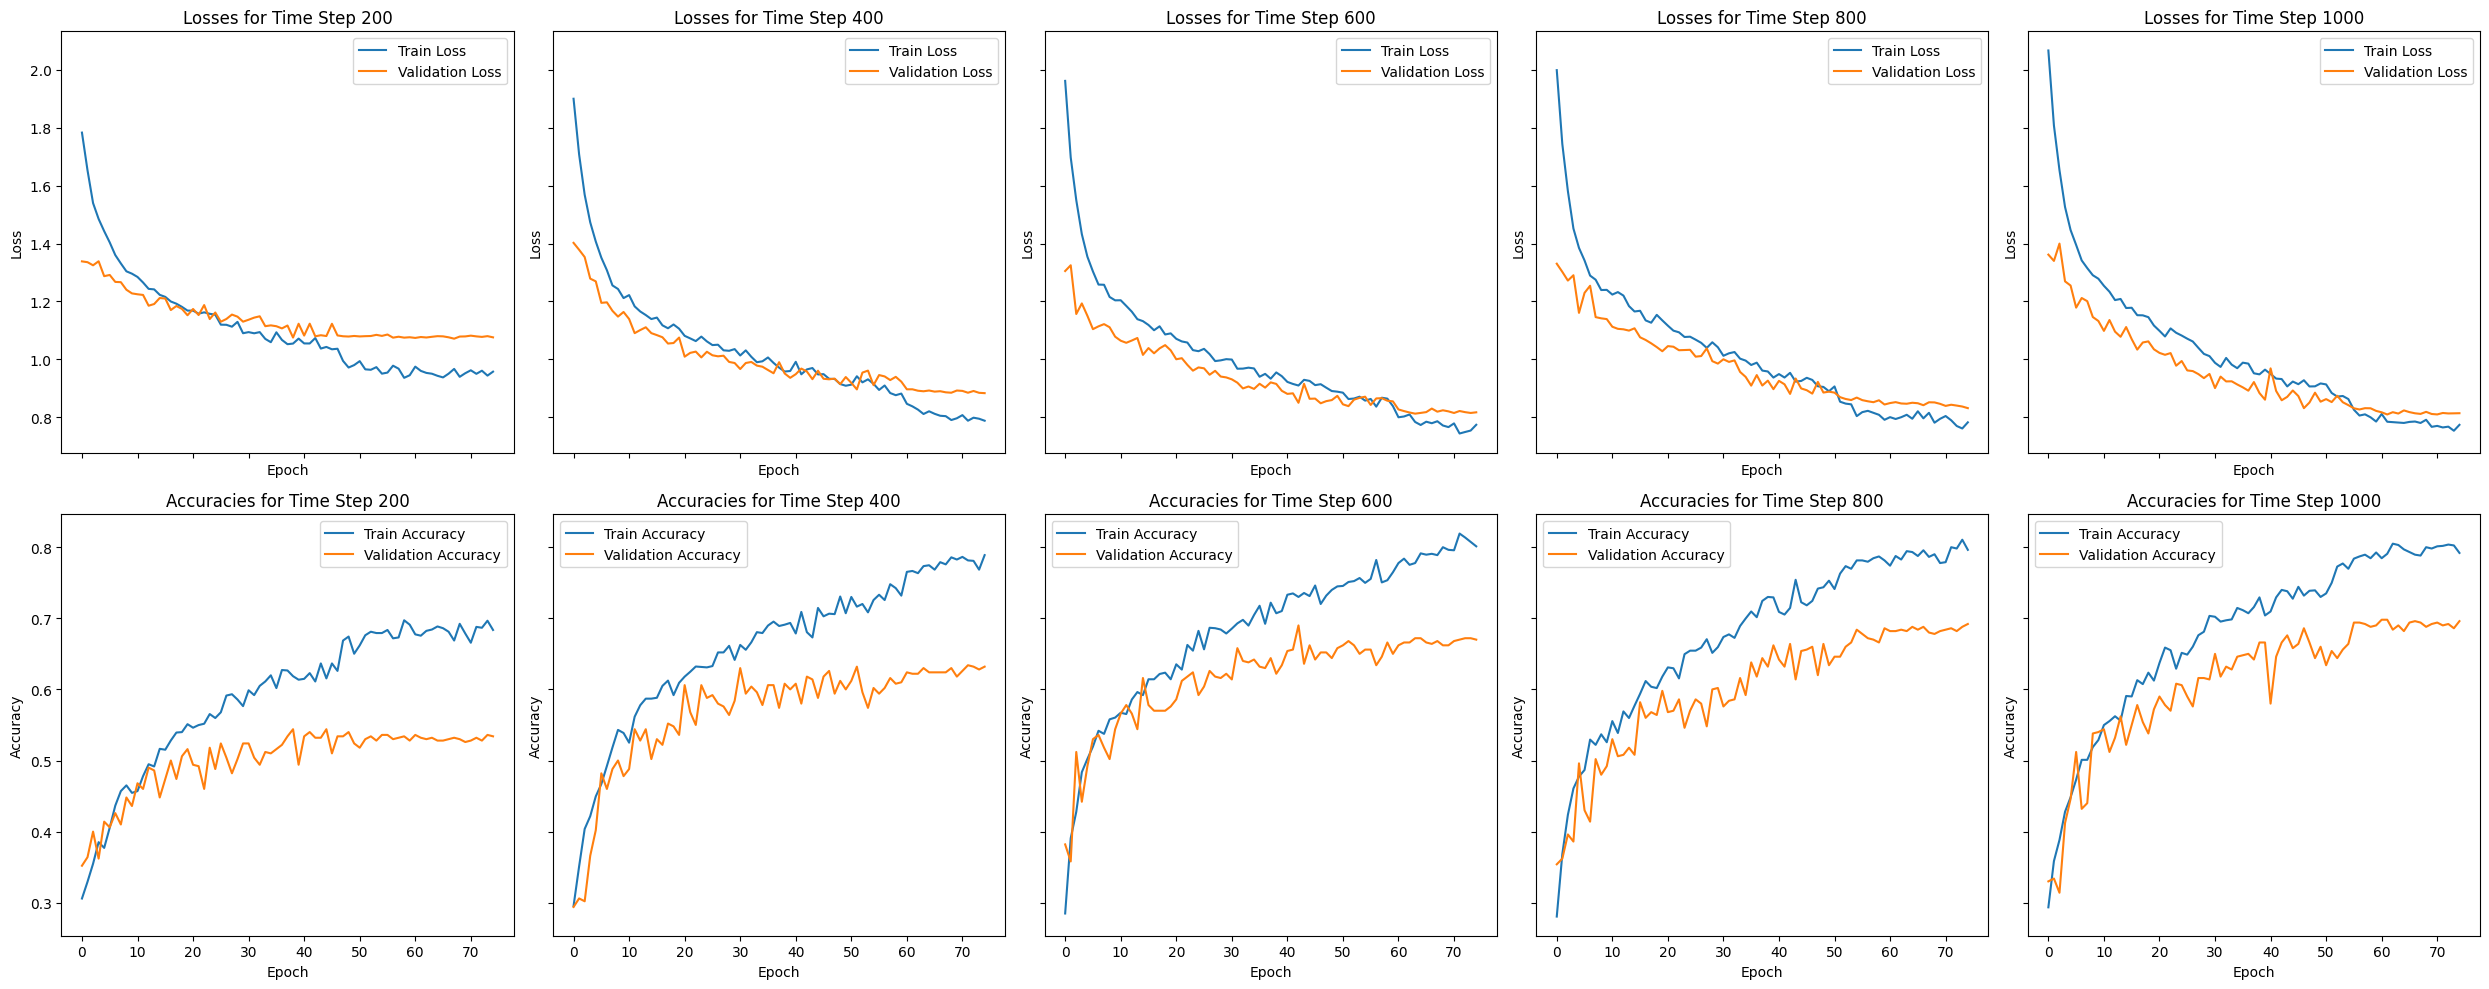

In [932]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10), sharex=True, sharey='row')

for i, (time_step, values) in enumerate(models.items()):
    axs[0, i].plot(values["train_lossv"], label="Train Loss")
    axs[0, i].plot(values["val_lossv"], label="Validation Loss")
    axs[0, i].set_title(f"Losses for {time_step} Time Steps")
    axs[0, i].set_xlabel("Epoch")
    axs[0, i].set_ylabel("Loss")
    axs[0, i].legend()

    axs[1, i].plot(values["train_accv"], label="Train Accuracy")
    axs[1, i].plot(values["val_accv"], label="Validation Accuracy")
    axs[1, i].set_title(f"Accuracies for {time_step} Time Steps")
    axs[1, i].set_xlabel("Epoch")
    axs[1, i].set_ylabel("Accuracy")
    axs[1, i].legend()

plt.tight_layout()
plt.show()

[0.45045045045045046, 0.7117117117117117, 0.7297297297297297, 0.7117117117117117, 0.7567567567567568]
[0.7716535433070866, 0.7559055118110236, 0.5669291338582677, 0.6614173228346457, 0.7007874015748031]
[0.375, 0.5729166666666666, 0.53125, 0.6770833333333334, 0.6354166666666666]
[0.5871559633027523, 0.5688073394495413, 0.7889908256880734, 0.7339449541284404, 0.7155963302752294]


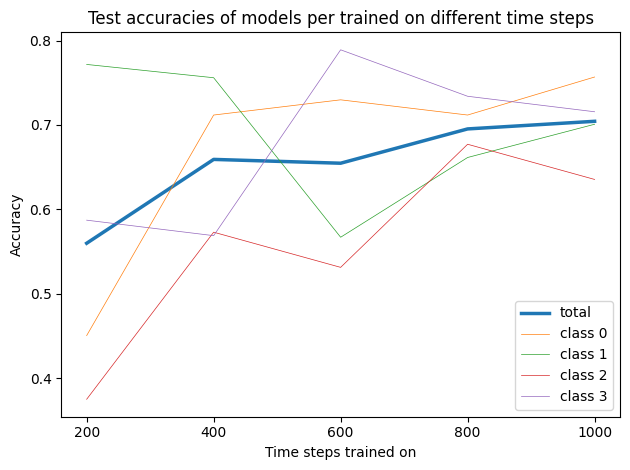

In [961]:
time_steps = list(models.keys())

test_accuracies = [values["test_accuracy"] for values in models.values()]
plt.plot(time_steps, test_accuracies, label="total", linewidth=2.5)

test_accuracies_per_class = []
for c in range(num_classes):
    test_accuracies_per_class.append([values["test_accuracies_per_class"][c] for values in models.values()])

for c, class_accuracies in enumerate(test_accuracies_per_class):
    print(class_accuracies)
    plt.plot(time_steps, class_accuracies, label=f"class {c}", linewidth=0.5)

plt.title("Test accuracies of models per trained on different time steps")
plt.xlabel("Time steps trained on")
plt.ylabel("Accuracy")
plt.xticks(time_steps)
plt.legend()
plt.tight_layout()
plt.show()

# Model (BrittneyCnnLstm)

## Create model

In [967]:
class BrittneyCnnLstm(nn.Module):
    """ A CNN model """
    def __init__(self):
        super(BrittneyCnnLstm, self).__init__()

        # Declare some fixed parameters
        self.num_in_channels = 22
        self.num_output_classes = 4
        self.num_filters_c1 = 15
        self.num_filters_c2 = 25
        self.num_filters_c3 = 75
        self.num_filters_c4 = 90
        self.lstm_hidden_size = 15

        # Declare layers
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_in_channels, out_channels=self.num_filters_c1, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=self.num_filters_c1),
            nn.Dropout(p=0.32)
        )

        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_filters_c1, out_channels=self.num_filters_c2, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=self.num_filters_c2),
            nn.Dropout(p=0.35)
        )

        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_filters_c2, out_channels=self.num_filters_c3, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=self.num_filters_c3),
            nn.Dropout(p=0.32)
        )

        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_filters_c3, out_channels=self.num_filters_c4, kernel_size=(5,1), padding="same"),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(num_features=self.num_filters_c4),
            nn.Dropout(p=0.35)
        )

        self.LstmLayer = nn.Sequential(
            # num_filters_c4 is interpreted by the lstm as time steps
            nn.LSTM(input_size=10, hidden_size=self.lstm_hidden_size, dropout=0.5, batch_first=True, bidirectional=False)
        )

        self.FcLayer = nn.Sequential(
            nn.LazyLinear(self.num_output_classes)
        )

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        # print(x.shape)
        x = x.view(-1, self.num_filters_c4, 10) # reshape to (batch_size, time_steps, input_size) that the lstm expects
        # x = self.LstmLayer(x)[1][0] # hidden state at the output of the *last* time step
        x = self.LstmLayer(x)[0] # hidden state at the output all time step
        # print(x.shape)
        # x = x.reshape(-1, 10) # (1, N, H) -> (N, H)
        x = x.reshape(-1, self.num_filters_c4 * self.lstm_hidden_size) # (1, N, H) -> (N, H)
        x = self.FcLayer(x)
        return x

In [968]:
# Create and verify model

## Instantiate model
model = BrittneyCnnLstm().to(device)
print("###########################")
print("#    Layer Parameters     #")
print("###########################")
print()
print(model)
print()

## Test model on dummy data
batch_size = 10
num_chans, height, width = 22, 800, 1  # input dimensions
test_input = torch.randn(batch_size, num_chans, height, width).to(device)
print("###########################")
print("#         Logits          #")
print("###########################")
print()
print(model(test_input).shape)  # should be (batch_size, num_classes) - contains the raw logits(scores) per class for each batch
print()

# # Print summary of model 
# print("###########################")
# print("#      Model Summary      #")
# print("###########################")
# print()
# summary(BrittneyCnnLstm().float(), input_size=(22,800,1)) # note: torchsummary uses float32 as the input dtype

###########################
#    Layer Parameters     #
###########################

BrittneyCnnLstm(
  (ConvLayer1): Sequential(
    (0): Conv2d(22, 15, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.32, inplace=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(15, 25, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.35, inplace=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(25, 75, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), paddi

In [969]:
loss_fn = nn.CrossEntropyLoss() # declare loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2) # declare optimization method
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=7)

## Train model

In [970]:
# Create datasets with any desired augmentations

## Define augmentations

class TrimTimeSteps(object):
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, X):
        return X[:,:,0:self.output_size,:]

class MaxPool(object):
    def __init__(self, pool_height):
        self.height = pool_height

    def __call__(self, X):
        return torch.max(X.reshape(X.shape[0], X.shape[1], -1, self.height, X.shape[3]), dim=3).values

class AvgPlusNoise(object):
    def __init__(self, pool_height):
        self.height = pool_height

    def __call__(self, X):
        X_avg = torch.mean(X.reshape(X.shape[0], X.shape[1], -1, self.height, X.shape[3]), dim=3)
        return X_avg + torch.normal(0.0, 0.5, X_avg.shape)
        
tsfrm_trim = TrimTimeSteps(800)
train_ds_trim = EEGDataset(type="train", transform_data=tsfrm_trim)
val_ds_trim = EEGDataset(type="val", transform_data=tsfrm_trim)

tsfrm_max = MaxPool(2)
train_ds_max = EEGDataset(type="train", transform_data=tsfrm_max)
val_ds_max = EEGDataset(type="val", transform_data=tsfrm_max)

training_dataset = torch.utils.data.ConcatDataset([
        train_ds_trim,
        # train_ds_max
    ])

validation_dataset = torch.utils.data.ConcatDataset([
        val_ds_trim,
        # val_ds_max
    ])

test_dataset = EEGDataset(type="test", transform_data=tsfrm_trim)

print(f"Length of new training data: {len(training_dataset)}")
print(f"Length of new validation data: {len(validation_dataset)}")
print(f"Length of new test data: {len(test_dataset)}")
print()
print(f"Shape of new training data: {training_dataset[0][0].shape}")
print(f"Shape of new validation data: {validation_dataset[0][0].shape}")
print(f"Shape of new test data: {test_dataset[0][0].shape}")


## Create pytorch dataloaders
bsz = 64
training_dataloader = DataLoader(dataset=training_dataset, batch_size=bsz, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=bsz, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=bsz, shuffle=False)

Length of new training data: 1615
Length of new validation data: 500
Length of new test data: 443

Shape of new training data: torch.Size([22, 800, 1])
Shape of new validation data: torch.Size([22, 800, 1])
Shape of new test data: torch.Size([22, 800, 1])


In [971]:
# Create training loop
def train(loss_vector, accuracy_vector):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    train_loss, train_correct_count = 0, 0
    for batch_idx, (X_batch, y_batch) in enumerate(training_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad() # zero out the gradient buffers
        logits = model(X_batch) # pass data through the network and acquire output
        loss = loss_fn(logits, y_batch) # calculate loss
        l1_norm = torch.norm(model.FcLayer[0].weight, p=1)
        loss += l1_norm * 0.01
        loss.backward() # backpropogate
        optimizer.step() # update weights

        # Calculate accuracy
        with torch.no_grad():
            train_loss += loss.data.item()
            y_hat_batch = torch.argmax(logits, dim=-1) # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            train_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    # Store loss and accuracy
    loss_vector.append(train_loss/len(training_dataloader))
    accuracy_vector.append(train_correct_count/len(training_dataloader.dataset))

# Create validation loop
def validate(loss_vector, accuracy_vector):
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the validation set
    val_loss, val_correct_count = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in validation_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            val_loss += loss_fn(logits, y_batch).data.item() # calculate loss
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            val_correct_count += torch.sum(y_hat_batch == y_batch, axis=-1)

    scheduler.step(val_loss)
    
    # Store loss and accuracy
    loss_vector.append(val_loss/len(validation_dataloader))
    accuracy_vector.append(val_correct_count/len(validation_dataloader.dataset))

In [972]:
%%time
from time import time

epochs = 100

train_lossv, train_accv = [], []
val_lossv, val_accv = [], []
for epoch in range(1, epochs + 1):
    epoch_start = time()
    train(train_lossv, train_accv)
    validate(val_lossv, val_accv)
    print(f"Epoch {epoch}/{epochs} ({(time() - epoch_start):.2f}s) - train loss: {train_lossv[-1]:.5f} - train acc: {train_accv[-1]:.5f} - val loss: {val_lossv[-1]:.5f} - val acc: {val_accv[-1]:.5f} - lr: {scheduler.get_last_lr()}")
    print()

Epoch 1/100 (3.16s) - train loss: 1.75007 - train acc: 0.28050 - val loss: 1.38117 - val acc: 0.28200 - lr: [0.001]

Epoch 2/100 (2.95s) - train loss: 1.43565 - train acc: 0.32136 - val loss: 1.38458 - val acc: 0.23600 - lr: [0.001]

Epoch 3/100 (2.70s) - train loss: 1.39978 - train acc: 0.31146 - val loss: 1.37834 - val acc: 0.23800 - lr: [0.001]

Epoch 4/100 (3.33s) - train loss: 1.37745 - train acc: 0.33808 - val loss: 1.32556 - val acc: 0.37600 - lr: [0.001]

Epoch 5/100 (2.91s) - train loss: 1.35850 - train acc: 0.37523 - val loss: 1.29755 - val acc: 0.39400 - lr: [0.001]

Epoch 6/100 (2.96s) - train loss: 1.32872 - train acc: 0.40062 - val loss: 1.26869 - val acc: 0.41000 - lr: [0.001]

Epoch 7/100 (2.60s) - train loss: 1.32048 - train acc: 0.41734 - val loss: 1.25803 - val acc: 0.44600 - lr: [0.001]

Epoch 8/100 (3.41s) - train loss: 1.31012 - train acc: 0.43467 - val loss: 1.24771 - val acc: 0.45600 - lr: [0.001]

Epoch 9/100 (2.80s) - train loss: 1.27271 - train acc: 0.45139 -

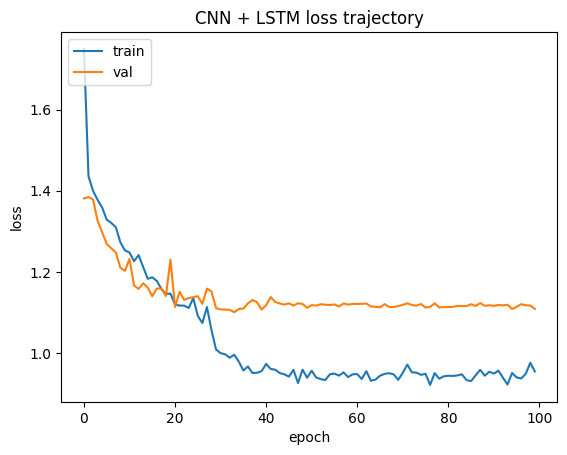

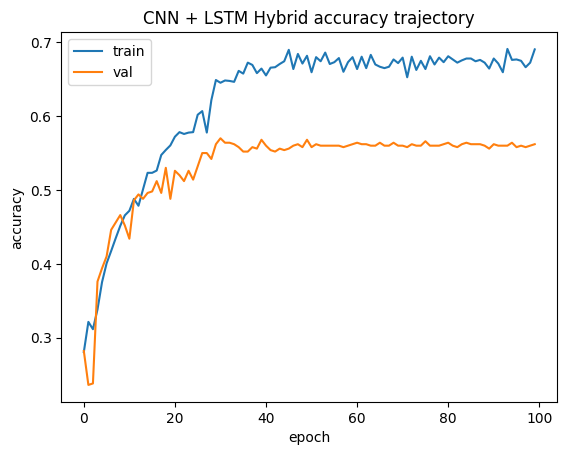

In [975]:
# Plot loss
plt.plot(train_lossv)
plt.plot(val_lossv)
plt.title('CNN + LSTM loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot accuracy
plt.plot(train_accv)
plt.plot(val_accv)
plt.title('CNN + LSTM Hybrid accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test model

In [976]:
num_classes = 4

def test():
    # Set model to evaluation mode
    model.eval()
    
    # Loop over each batch from the test set
    test_correct_count_per_class = np.zeros(4) # no. of correctly classified examples for each class (idx is class_id)
    test_count_per_class = np.zeros(4) # no. of examples for each class (idx is class_id)
    test_correct_count = 0
    with torch.no_grad(): # speed things up because we kn
        for X_batch, y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch).detach() # pass data through the network and acquire output
            y_hat_batch = logits.data.max(dim=1)[1] # get the indices of the classes with the max score
            # y_batch = torch.argmax(y_batch.data, dim=1) # convert targets back from one-hot to compare to pred.
            test_correct_count += torch.sum(y_hat_batch == y_batch, dim=-1) # accumulate no. of correctly classified examples

            correct_idxs = (y_hat_batch == y_batch)
            for cls in range(num_classes):
                test_count_per_class[cls] += torch.sum(y_batch == cls) # accumulate no. of examples per class
                test_correct_count_per_class[cls] += torch.sum(y_batch[correct_idxs] == cls) # accumulate no. of correctly classified examples per class
                

    accuracy = test_correct_count / len(test_dataloader.dataset)
    # accuracies_per_class = {class_id: acc for class_id, acc in zip(range(num_classes), test_correct_count_per_class/test_count_per_class)}
    accuracies_per_class = test_correct_count_per_class/test_count_per_class

    return accuracy, accuracies_per_class

accuracy, accuracies_per_class = test()
print(f"Total Accuracy: {accuracy}")
for c, acc in enumerate(accuracies_per_class):
    print(f"    - Accuracy for class {c}: {acc}")

Total Accuracy: 0.5372460496613995
    - Accuracy for class 0: 0.5405405405405406
    - Accuracy for class 1: 0.5275590551181102
    - Accuracy for class 2: 0.6666666666666666
    - Accuracy for class 3: 0.43119266055045874
